In [2]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import math 

#https://www.youtube.com/watch?v=U7HRKjlXK-Y


In [6]:
images = [cv2.imread(file, 0) for file in glob.glob("img/*.png")]


In [49]:
img = images[0]

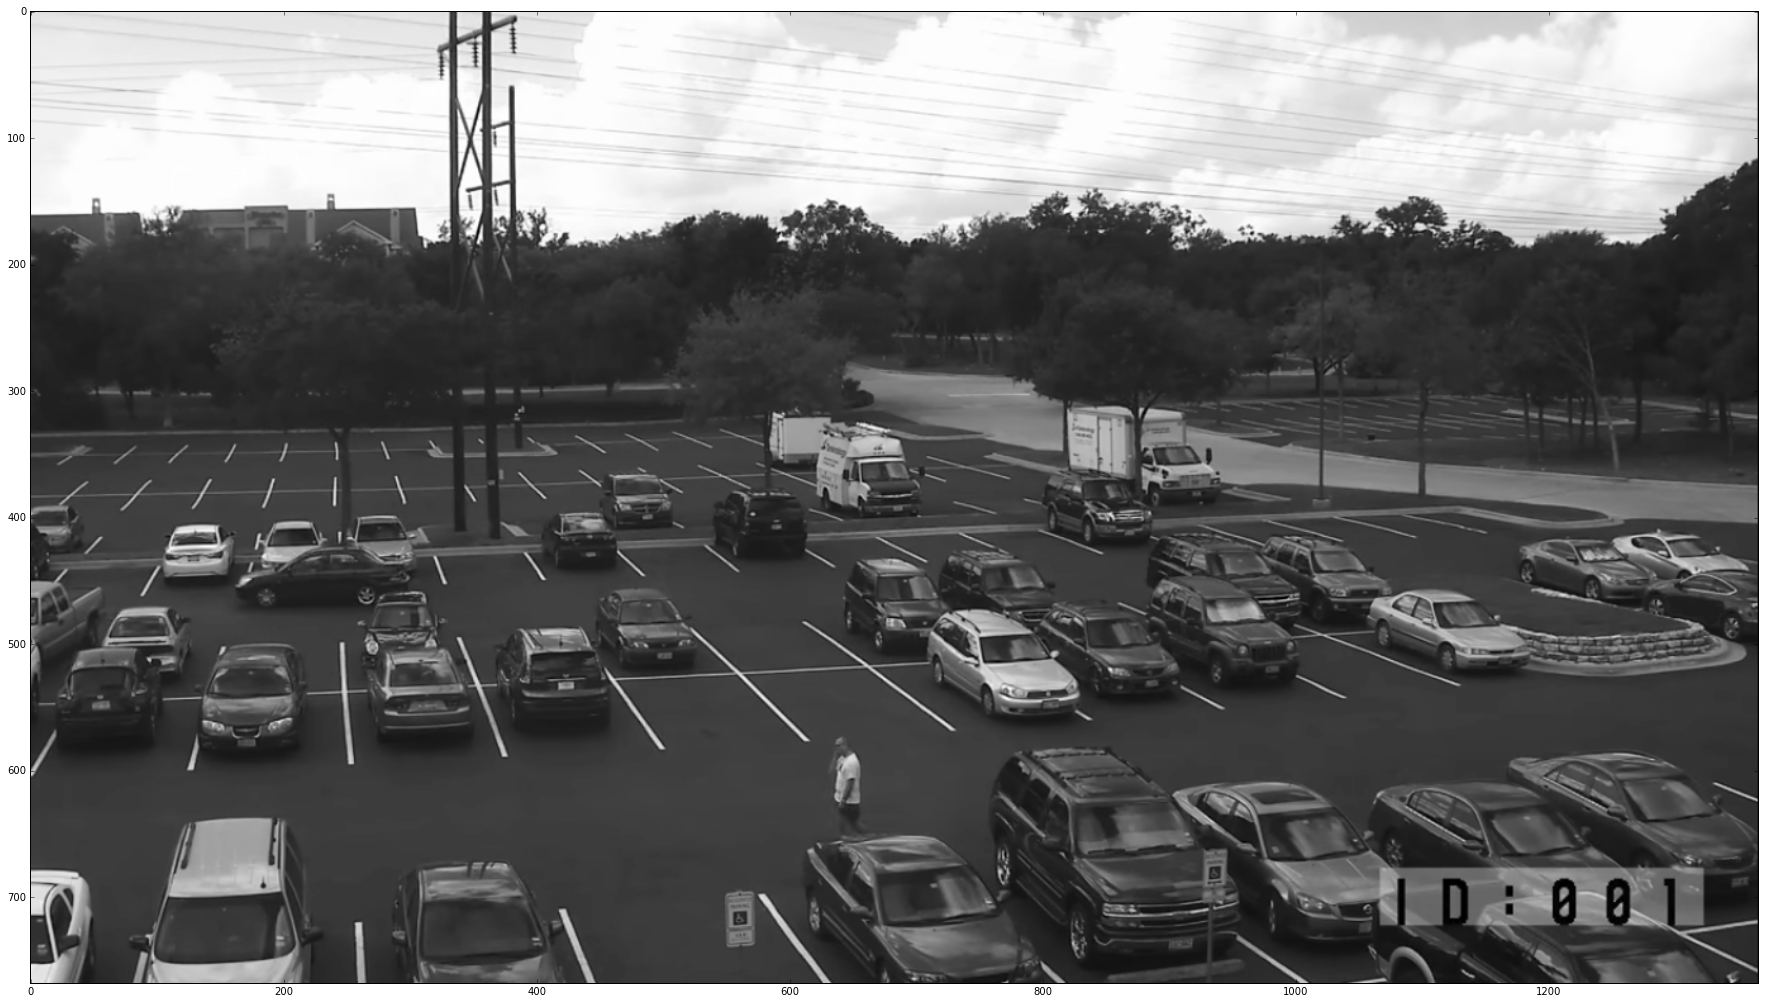

In [29]:
plt.imshow(img, cmap='gray')
plt.subplots_adjust(left=0.0, right=4.0, bottom=0.0, top=4.0)
plt.show()

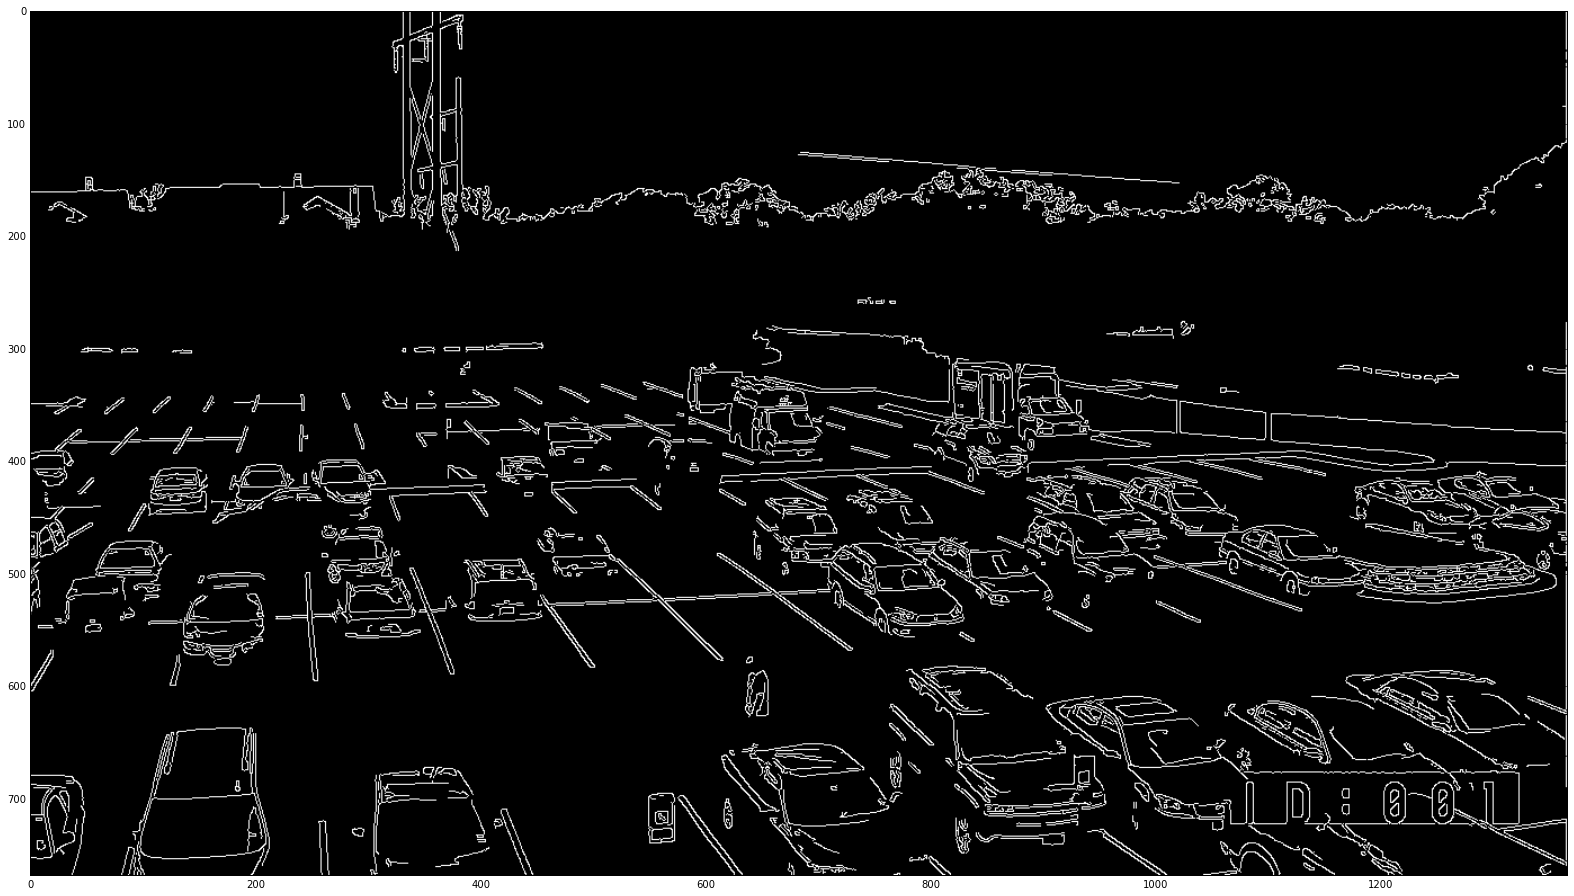

In [45]:
edges = cv2.Canny(img,100,300)
plt.imshow(edges, cmap='gray')
plt.subplots_adjust(left=0.0, right=4.0, bottom=0.0, top=3.0) 
plt.show()

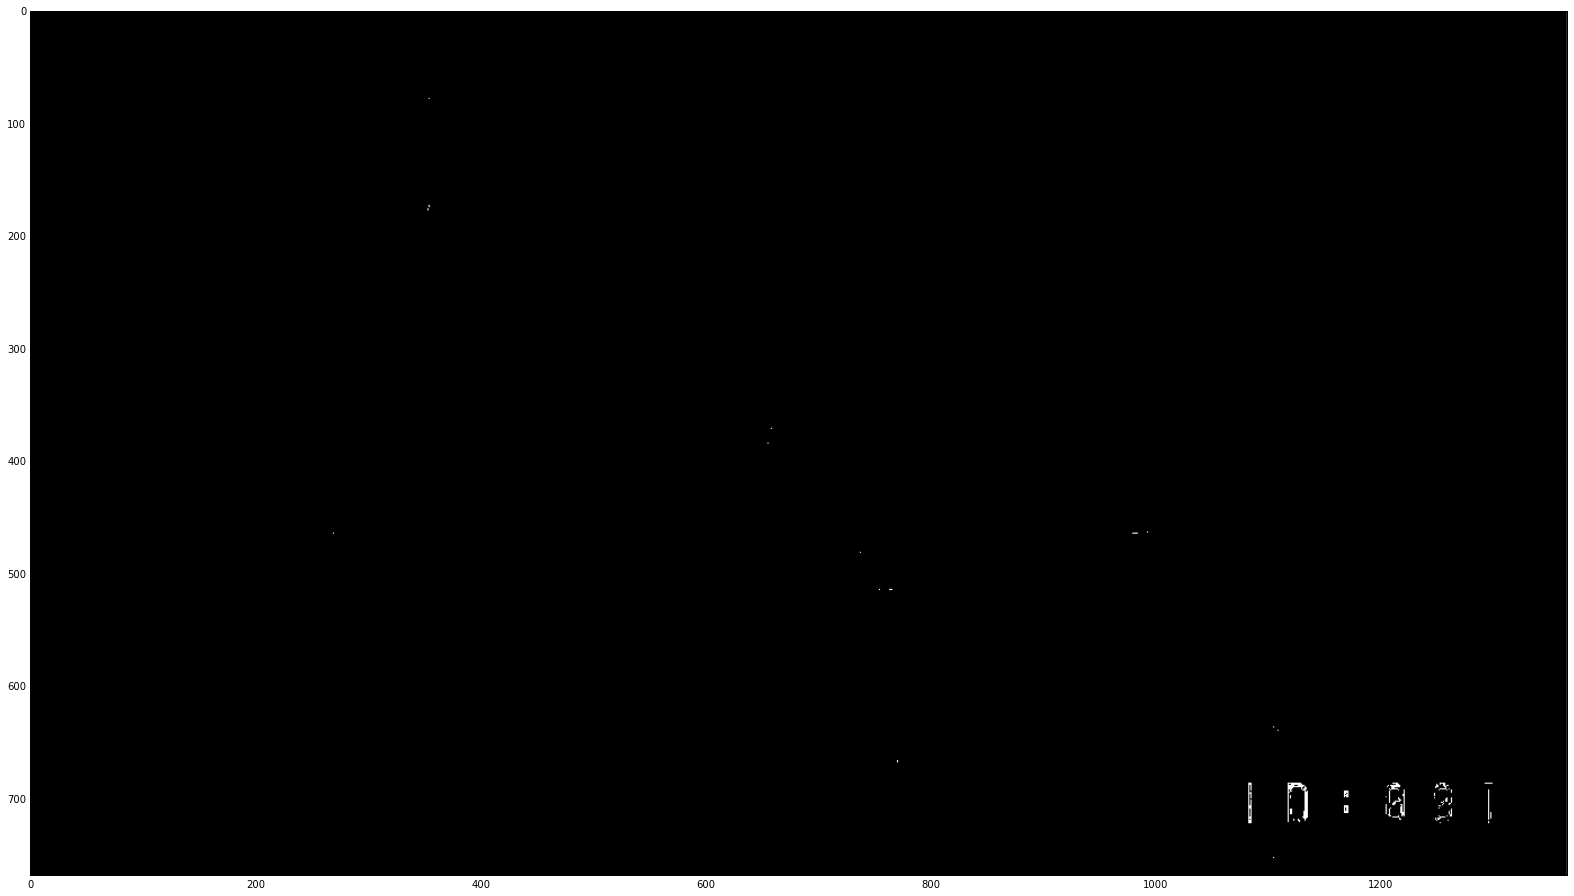

In [50]:
fgbg = cv2.createBackgroundSubtractorMOG2()

fgmask = fgbg.apply(img)
plt.imshow(fgmask, cmap='gray')
plt.subplots_adjust(left=0.0, right=4.0, bottom=0.0, top=3.0) 
plt.show()
